Script iniciado. Período de análise: 2024-01-01 a 2025-11-05
Carregando ROI e extraindo coordenadas...
Coordenadas do ROI (Bounding Box): [np.float64(-64.9906904834249), np.float64(-12.49828980254751), np.float64(-63.668907969056356), np.float64(-11.468799703293735)]
Iniciando download de dados (2024-01-01 a 2025-11-05) para o ROI...
Fontes: ['VIIRS_SNPP_SP', 'VIIRS_NOAA20_SP', 'MODIS_SP']
Baixando bloco de 10 dias a partir de 2024-01-01...
Baixando bloco de 10 dias a partir de 2024-01-11...
  -> Nenhum dado para MODIS_SP no bloco 2024-01-11.
Baixando bloco de 10 dias a partir de 2024-01-21...
Baixando bloco de 10 dias a partir de 2024-01-31...
Baixando bloco de 10 dias a partir de 2024-02-10...
  -> Nenhum dado para MODIS_SP no bloco 2024-02-10.
Baixando bloco de 10 dias a partir de 2024-02-20...
  -> Nenhum dado para MODIS_SP no bloco 2024-02-20.
Baixando bloco de 10 dias a partir de 2024-03-01...
  -> Nenhum dado para VIIRS_NOAA20_SP no bloco 2024-03-01.
Baixando bloco de 10 dias a 

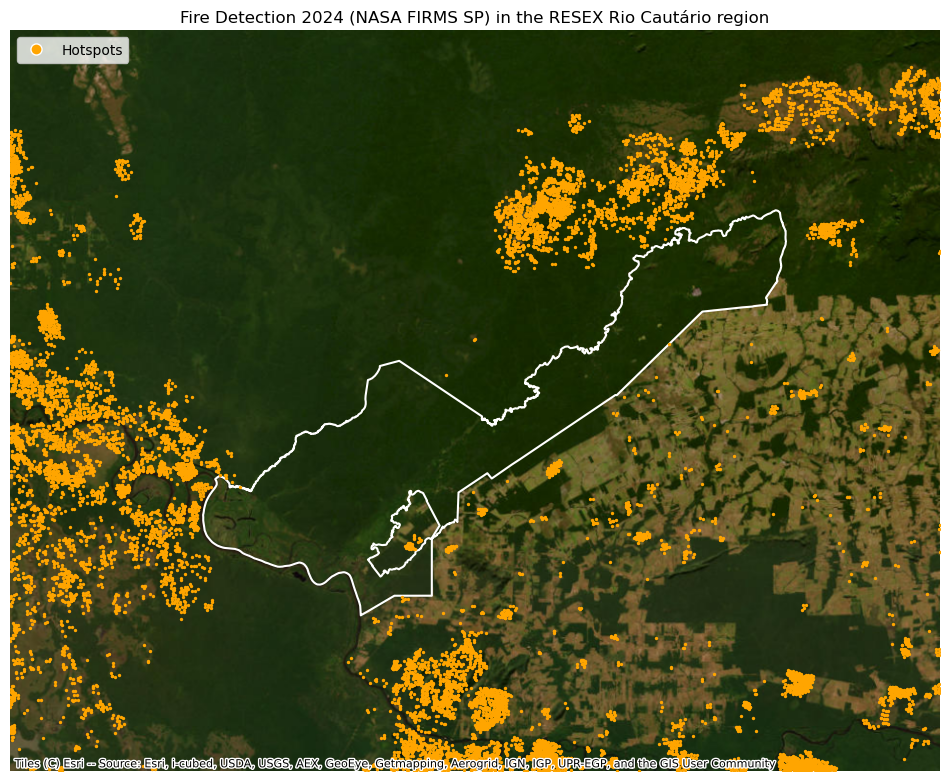


Gerando mapa: Fire Detection 2025 (NASA FIRMS SP) in the RESEX Rio Cautário region (through 2025-11-05)
Adicionando mapa base (ficará no fundo)...
Exibindo mapa.


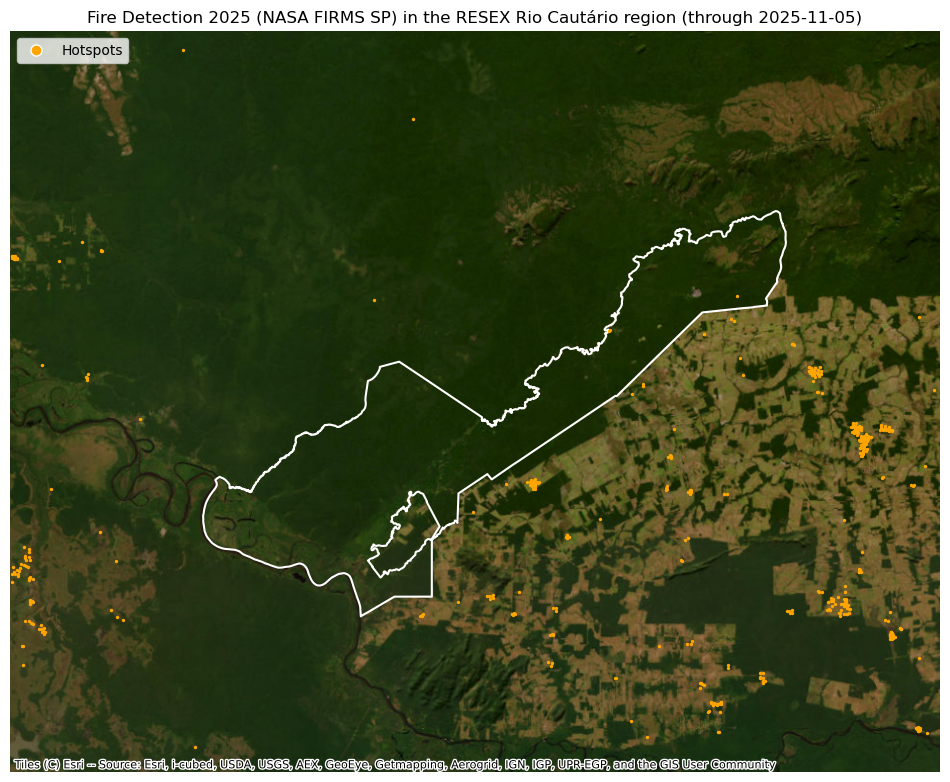

In [36]:
# Importação das bibliotecas
import contextily as cx
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import date, timedelta
import os
from matplotlib.lines import Line2D

# --- Configurações do Usuário ---
FIRMS_API_KEY = "951af9737d347e1892862e8ff79f9230"
ROI_FILE_PATH = "C:/Users/JesseBurlamaque/Downloads/roi_RC.geojson"
POLYGON_TO_PLOT_PATH = "C:/Users/JesseBurlamaque/Downloads/pa_cautario.geojson"

# --- CAMINHOS DE SAÍDA ---
OUTPUT_DIR = os.path.dirname(ROI_FILE_PATH)
OUTPUT_FILE_2024 = os.path.join(OUTPUT_DIR, "focos_confiaveis_2024.geojson")
OUTPUT_FILE_2025 = os.path.join(OUTPUT_DIR, "focos_confiaveis_2025.geojson")

# --- ESCOLHA DOS SENSORES (FONTES) ---
SOURCES_TO_DOWNLOAD = [
    "VIIRS_SNPP_SP",   # VIIRS Suomi-NPP
    "VIIRS_NOAA20_SP", # VIIRS NOAA-20 (JPSS-1)
    "MODIS_SP"         # MODIS (1 km)
]

# Datas de início e fim
START_DATE = "2024-01-01"
END_DATE = date.today().strftime('%Y-%m-%d')

# --- Funções Auxiliares ---

def get_roi_coordinates(filepath):
    print("Carregando ROI e extraindo coordenadas...")
    gdf = geopandas.read_file(filepath)
    gdf = gdf.to_crs(epsg=4326)
    bounds = gdf.total_bounds
    return [bounds[0], bounds[1], bounds[2], bounds[3]]

def download_firms_data(roi_coords, start_date_str, end_date_str, api_key, sources_list):
    """
    Baixa os dados FIRMS por blocos de dias e retorna um DataFrame combinado com a coluna 'sensor_source'.
    """
    roi_str = ",".join(map(str, roi_coords))
    current_date = pd.to_datetime(start_date_str)
    end_date_dt = pd.to_datetime(end_date_str)
    day_range = 10

    all_data_frames = []
    print(f"Iniciando download de dados ({start_date_str} a {end_date_str}) para o ROI...")
    print(f"Fontes: {sources_list}")

    while current_date <= end_date_dt:
        date_str = current_date.strftime('%Y-%m-%d')
        days_left = (end_date_dt - current_date).days
        current_day_range = min(day_range, days_left + 1)
        if current_day_range <= 0:
            break

        print(f"Baixando bloco de {current_day_range} dias a partir de {date_str}...")
        for source in sources_list:
            url = f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/{api_key}/{source}/{roi_str}/{current_day_range}/{date_str}"
            try:
                df_chunk = pd.read_csv(url)
                required_columns = ['latitude', 'longitude', 'acq_date', 'acq_time', 'confidence']
                if df_chunk.empty:
                    print(f"  -> Nenhum dado para {source} no bloco {date_str}.")
                elif not all(col in df_chunk.columns for col in required_columns):
                    if 'Invalid API call' in df_chunk.columns[0]:
                        print(f"  -> Erro: 'Invalid API call' para {source}.")
                    elif 'confidence' not in df_chunk.columns:
                        print(f"  -> Erro: Coluna 'confidence' não encontrada para {source} no bloco {date_str}.")
                    else:
                        print(f"  -> Aviso: Colunas ausentes para {source} no bloco {date_str}.")
                else:
                    df_chunk['sensor_source'] = source
                    all_data_frames.append(df_chunk)
            except Exception as e:
                print(f"  -> Erro ao baixar dados para {source} no bloco {date_str}: {e}")

        current_date += timedelta(days=current_day_range)

    non_empty_dfs = [df for df in all_data_frames if not df.empty]
    if not non_empty_dfs:
        print("Nenhum dado foi baixado no período total.")
        return None

    combined_df = pd.concat(non_empty_dfs, ignore_index=True)

    # Clipping via bounding box por segurança
    min_lon, min_lat, max_lon, max_lat = roi_coords
    df_filtered = combined_df[
        (combined_df['longitude'] >= min_lon) & (combined_df['longitude'] <= max_lon) &
        (combined_df['latitude']  >= min_lat) & (combined_df['latitude']  <= max_lat)
    ].copy()

    print(f"Download concluído. Total de {len(df_filtered)} detecções (antes do filtro de confiança).")
    return df_filtered

def create_fire_map_orange(gdf_list, poly_to_plot, map_extent, title_str):
    """
    Plota uma lista de GeoDataFrames com pontos laranja e legenda genérica 'Hotspots'.
    """
    print(f"\nGerando mapa: {title_str}")
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xlim(map_extent[0], map_extent[2])
    ax.set_ylim(map_extent[1], map_extent[3])
    ax.set(title=title_str)
    ax.set_axis_off()

    if poly_to_plot is not None:
        try:
            poly_to_plot.plot(ax=ax, color='none', edgecolor='white', linewidth=1.5)
        except Exception as e:
            print(f"Aviso: Não foi possível plotar o polígono {POLYGON_TO_PLOT_PATH}. Erro: {e}")

    # Plota cada camada (SNPP, NOAA20, MODIS), todas em laranja
    for gdf in gdf_list:
        if gdf is not None and not gdf.empty:
            gdf.plot(ax=ax, color='orange', markersize=2)

    # Legenda genérica (em inglês, sem contagens)
    legend_handle = Line2D([0], [0], marker='o', color='w', label='Hotspots',
                           markerfacecolor='orange', markersize=8, linestyle='None')
    ax.legend(handles=[legend_handle], loc='upper left', markerscale=1)

    print("Adicionando mapa base (ficará no fundo)...")
    #cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.CartoDB.Positron)
    cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.Esri.WorldImagery)

    print("Exibindo mapa.")
    plt.show()

# --- Processamento Principal ---

print(f"Script iniciado. Período de análise: {START_DATE} a {END_DATE}")
roi_coords = get_roi_coordinates(ROI_FILE_PATH)
print(f"Coordenadas do ROI (Bounding Box): {roi_coords}")

df_all = download_firms_data(roi_coords, START_DATE, END_DATE, FIRMS_API_KEY, SOURCES_TO_DOWNLOAD)

if df_all is None or df_all.empty:
    print("Nenhum dado foi baixado. O script será encerrado.")
else:
    print(f"Total de detecções baixadas: {len(df_all)}")

    # Normalização defensiva do campo confidence
    if 'confidence' not in df_all.columns:
        print("Erro fatal: A coluna 'confidence' não foi encontrada nos dados baixados. Não é possível filtrar ou salvar.")
        raise SystemExit(1)

    df_all['confidence_norm'] = df_all['confidence'].astype(str).str.strip().str.lower()

    # Filtro nominal e high (VIIRS e MODIS)
    valid_nominal_high = {'n', 'h', 'nominal', 'high'}

    # Separação por satélite/fonte
    is_snpp = df_all['sensor_source'] == 'VIIRS_SNPP_SP'
    is_noaa20 = df_all['sensor_source'] == 'VIIRS_NOAA20_SP'
    is_modis = df_all['sensor_source'] == 'MODIS_SP'

    # Filtragem por confiança separadamente
    df_snpp = df_all[is_snpp & (df_all['confidence_norm'].isin(valid_nominal_high))].copy()
    df_noaa20 = df_all[is_noaa20 & (df_all['confidence_norm'].isin(valid_nominal_high))].copy()
    df_modis  = df_all[is_modis & (df_all['confidence_norm'].isin(valid_nominal_high))].copy()

    print(f"Detecções S-NPP (n/h): {len(df_snpp)}")
    print(f"Detecções NOAA-20 (n/h): {len(df_noaa20)}")
    print(f"Detecções MODIS (n/h): {len(df_modis)}")

    # Converte datetime por subset e por ano (evita NaT afetar outro ano)
    def to_year_gdf(df, year):
        if df is None or df.empty:
            return geopandas.GeoDataFrame(df, geometry=[], crs="EPSG:4326")
        # filtra o ano primeiro via acq_date (string) para minimizar NaT fora do ano
        df_year = df[df['acq_date'].str.startswith(str(year))].copy()
        if df_year.empty:
            return geopandas.GeoDataFrame(df_year, geometry=[], crs="EPSG:4326")
        # cria datetime com zero padding e coerce
        time_str = df_year['acq_time'].astype(str).str.strip().str.split('.').str[0].str.zfill(4)
        df_year['acq_datetime'] = pd.to_datetime(
            df_year['acq_date'] + ' ' + time_str, format='%Y-%m-%d %H%M', errors='coerce'
        )
        # drop NaT locais a este ano
        df_year = df_year[df_year['acq_datetime'].notna()].copy()
        if df_year.empty:
            return geopandas.GeoDataFrame(df_year, geometry=[], crs="EPSG:4326")
        gdf = geopandas.GeoDataFrame(
            df_year,
            geometry=geopandas.points_from_xy(df_year.longitude, df_year.latitude),
            crs="EPSG:4326"
        )
        return gdf

    # GDFs por ano e por satélite
    gdf_snpp_2024   = to_year_gdf(df_snpp, 2024)
    gdf_noaa20_2024 = to_year_gdf(df_noaa20, 2024)
    gdf_modis_2024  = to_year_gdf(df_modis, 2024)

    gdf_snpp_2025   = to_year_gdf(df_snpp, 2025)
    gdf_noaa20_2025 = to_year_gdf(df_noaa20, 2025)
    gdf_modis_2025  = to_year_gdf(df_modis, 2025)

    # Exporta GeoJSON por ano unindo as três fontes daquele ano
    def export_union(gdfs, out_path):
        gdf_union = pd.concat([g for g in gdfs if g is not None and not g.empty], ignore_index=True) \
                     if any(g is not None and not g.empty for g in gdfs) else None
        if gdf_union is None:
            print(f"Nenhum foco para salvar em {out_path}.")
            return
        gdf_union = geopandas.GeoDataFrame(gdf_union, geometry='geometry', crs="EPSG:4326")
        try:
            gdf_union.to_file(out_path, driver="GeoJSON")
            print(f"Arquivo salvo: {out_path}")
        except Exception as e:
            print(f"ERRO ao salvar {out_path}: {e}")

    export_union([gdf_snpp_2024, gdf_noaa20_2024, gdf_modis_2024], OUTPUT_FILE_2024)
    export_union([gdf_snpp_2025, gdf_noaa20_2025, gdf_modis_2025], OUTPUT_FILE_2025)

    # Carrega polígono
    try:
        print(f"Carregando polígono para plotar: {POLYGON_TO_PLOT_PATH}")
        gdf_polygon = geopandas.read_file(POLYGON_TO_PLOT_PATH).to_crs("EPSG:4326")
    except Exception as e:
        print(f"ERRO: Não foi possível carregar o polígono {POLYGON_TO_PLOT_PATH}. Erro: {e}")
        gdf_polygon = None

    # Títulos em inglês
    title_2024 = "Fire Detection 2024 (NASA FIRMS SP) in the RESEX Rio Cautário region"
    title_2025 = f"Fire Detection 2025 (NASA FIRMS SP) in the RESEX Rio Cautário region (through {END_DATE})"

    # Mapas por ano (camadas por satélite, ambos em laranja) + legenda genérica
    create_fire_map_orange(
        gdf_list=[gdf_snpp_2024, gdf_noaa20_2024, gdf_modis_2024],
        poly_to_plot=gdf_polygon,
        map_extent=roi_coords,
        title_str=title_2024
    )
    create_fire_map_orange(
        gdf_list=[gdf_snpp_2025, gdf_noaa20_2025, gdf_modis_2025],
        poly_to_plot=gdf_polygon,
        map_extent=roi_coords,
        title_str=title_2025
    )
